# Detecção de máscaras



## Instalação de módulos

In [2]:
!pip install tensorflow

  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=19558 sha256=8cfd8ef6a1ac7f3d3b06cf0372c7f041028b7a2f5cfcf30e1539bd25f4a7d541
  Stored in directory: c:\users\biel\appdata\local\pip\cache\wheels\62\76\4c\aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=5aabe78b484b4548003f576d65a2745c752e6a31475606532bc870eea8bb7087
  Stored in directory: c:\users\biel\appdata\local\pip\cache\wheels\3f\e3\ec\8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
Successfully built wrapt termcolor
  Attempting uninstall: six
    Found existing installation: six 1.14.0
    Uninstalling six-1.14.0:
      Successfully uninstalled six-1.14.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.1
    Uninstalling numpy-1.18.1:
      Successfully uninstalled numpy-1.18.1
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.11.2
    Uninstalling wrapt-1.11.2:
    

ERROR: pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
ERROR: pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
ERROR: astroid 2.3.3 requires typed-ast<1.5,>=1.4.0; implementation_name == "cpython" and python_version < "3.8", which is not installed.
ERROR: astroid 2.3.3 has requirement wrapt==1.11.*, but you'll have wrapt 1.12.1 which is incompatible.


In [3]:
!pip install pygame

In [4]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=f411141742a7635b1c97953ae55f112be76c6e4f6414c76a71d29e0029f8a5a6
  Stored in directory: c:\users\biel\appdata\local\pip\cache\wheels\86\d7\0a\4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [9]:
!pip install opencv-python

## Modelo de deep learning

### Libs utilizadas

Tensorflow + Keras
- Utilizado para pré-processamento das imagens e para criação do modelo da rede neural

Sklearn 
- Utilizado para separar o dataset em treino e teste, codificar as labels e validar o modelo de classificação

Matplotlib 
- Utilizado para plotar as curvas de erro e acurácia

Demais Libs
- Utilizadas para operações diversas: buscar imagens, converção de tipos de dados e etc

In [83]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

### Parametros

Parametros pré-estabelecidos para aplicação no modelo

- Learning Rate
- Número de épocas
- Batch size
- Semente do random state

In [84]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32
SEED = 42

### Pré-processamento

- Carregando imagens com o uso do imutils
- Inicializando as listas onde vão ser armazenadas os dados das imagens e as labels

In [93]:
print("Carregando imagens...")
imagePaths = list(paths.list_images("dataset/"))
data = []
labels = []
print("Imagens carregadas com sucesso...")

Carregando imagens...
Imagens carregadas com sucesso...


Loop sobre os caminhos das imagens para:
- Extração das labels
- Processamento e conversão das imagens
- Inserção nas listas inicializadas anteriormente

In [94]:
print("Pré-processando imagens...")
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
print("Imagens pré-processadas com sucesso!")

Pré-processando imagens...
Imagens pré-processadas com sucesso!


- Performar One-hot encoding nas labels para transformar em formato númerico

In [95]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

Divisão do dataset em dados de treino e teste utilizando
- 80% dos dados para treino
- 20% dos dados para teste

In [96]:
(trainX, testX, trainY, testY) = train_test_split(data,labels,test_size=0.20, 
                                                  stratify=labels,random_state=SEED)

- Inicializando algoritmo de Data augmentation para geração de imagens diversificadas

In [97]:
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,
                         width_shift_range=0.2,height_shift_range=0.2,
                         shear_range=0.15,horizontal_flip=True,
                         fill_mode="nearest")

### Rede Neural

- Inicializando a rede neural

In [98]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

D:\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:377: RuntimeWarning: coroutine 'alarm' was never awaited
  with g.as_default(), ops.name_scope(name) as scope:


Compilando o modelo e fazendo uso de:
- Adam como otimizador
- Binary crossentropy como loss function
- Acurácia como principal métrica

In [99]:
print("Compilando o modelo...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Modelo compilado com sucesso!!!")

Compilando o modelo...
Modelo compilado com sucesso!!!


- Treinando a rede neural

In [100]:
print("Iniciando o treinamento...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),
              steps_per_epoch=len(trainX) // BS,
              validation_data=(testX, testY),
              validation_steps=len(testX) // BS,
              epochs=EPOCHS)
print("Treinamento concluído!!!")

Iniciando o treinamento...
Epoch 1/20
34/34 [==============================] - 44s 1s/step - loss: 0.7043 - accuracy: 0.6503 - val_loss: 0.2707 - val_accuracy: 0.9783
Epoch 2/20
34/34 [==============================] - 31s 896ms/step - loss: 0.2725 - accuracy: 0.9474 - val_loss: 0.1291 - val_accuracy: 0.9928
Epoch 3/20
34/34 [==============================] - 33s 971ms/step - loss: 0.1382 - accuracy: 0.9804 - val_loss: 0.0786 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 32s 938ms/step - loss: 0.0943 - accuracy: 0.9880 - val_loss: 0.0551 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 27s 790ms/step - loss: 0.0809 - accuracy: 0.9802 - val_loss: 0.0422 - val_accuracy: 0.9964
Epoch 6/20
34/34 [==============================] - 26s 752ms/step - loss: 0.0509 - accuracy: 0.9945 - val_loss: 0.0346 - val_accuracy: 0.9964
Epoch 7/20
34/34 [==============================] - 27s 778ms/step - loss: 0.0442 - accuracy: 0.9967 - val_loss: 0.030

### Validação

- Validando o modelo

In [101]:
# make predictions on the testing set
print("Iniciando a validação...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

Iniciando a validação...
                      precision    recall  f1-score   support

   dataset/with_mask       1.00      1.00      1.00       138
dataset/without_mask       1.00      1.00      1.00       138

            accuracy                           1.00       276
           macro avg       1.00      1.00      1.00       276
        weighted avg       1.00      1.00      1.00       276



- Salvando o modelo em disco

In [102]:
# serialize the model to disk
print("Salvando modelo no disco...")
model.save("modelo_mascara.model", save_format="h5")
print("Salvo com sucesso!")

Salvando modelo no disco...
Salvo com sucesso!


- Plotando curvas de erro e acurácia

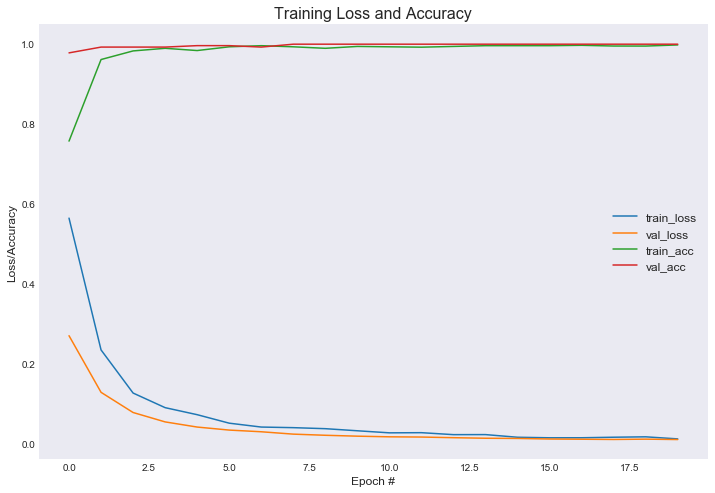

In [103]:
N = EPOCHS
plt.style.use("seaborn-dark")
plt.figure(figsize=(12,8))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy", fontsize="16")
plt.xlabel("Epoch #", fontsize="12")
plt.ylabel("Loss/Accuracy", fontsize="12")
plt.legend(loc="best", fontsize="12")
#plt.savefig("grafico.jpg")

## Reconhecimento por video

### Libs Utilizadas

Tensorflow + Keras
- Utilizado para pré-processamento das imagens e para carregar o modelo criado anteriormente

Pygame
- Utilizado para a criação de um alarme

ImUtils
- Utilizado para a captura de vídeo

OpenCV
- Para determinadas operações de nos frames do vídeo

In [104]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
from pygame import mixer
import numpy as np
import imutils
import time
import cv2
import os

- Inicialização do alarme

In [105]:
mixer.init()
sound = mixer.Sound('alarme/alarme.wav')

### Função para detecção das máscaras

- Passado como parametros o frame do vídeo, um modelo de reconhecimento da face e um modelo de detecção de máscara
- Criação de um blob da imagem para fazer as predições de face
- Inicialização das listas auxiliares para armazenamento das faces, localizações das faces e das previsões
- Loop sobre as faces detectadas para marcar a posição da face, processar os frames e aplicar no modelo de detecção de máscara
- Por fim, retornar a localização das faces e as predições de com ou sem máscara

In [116]:
def detectar_mascara(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))
    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []
    
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))
            # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)
    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)

### Função para alerta

- Se for detectada a presença de uma pessoa sem máscara, soará um bip e serão tiradas fotos do individuo

In [124]:
def alarm(label, count_incidente, flag_pessoa, frame, tresh):
    if label.split(':')[0] == "SEM mascara" and tresh > 0.98:
        if flag_pessoa == 0:
            cv2.imwrite("fotos/pessoa{}.jpg".format(count_incidente), frame)
        sound.play(maxtime=1000)
        flag_pessoa = 1
        count_incidente += 1
        #print("Beep")
    else:
        flag_pessoa = 0
    #print(flag_pessoa)
    return count_incidente, flag_pessoa

### Carregar os modelos

In [108]:
print("Carregando modelo para detecção de faces...")
prototxtPath = os.path.sep.join(["deploy.prototxt"])
weightsPath = os.path.sep.join(["res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
print("Carregando modelo para detecção de máscaras...")
maskNet = load_model("modelo_mascara.model")

Carregando modelo para detecção de faces...
Carregando modelo para detecção de máscaras...


### Execução do vídeo

- Iniciada a execução do vídeo
- Entrada no loop responsável pela captura dos frames
- Chamada da função para detecção de máscara sobre cada frame
- Retorno da função utilizada para desenhar na tela um retangulo para demarcar a face e identificar se está sendo usada a máscara
- Não identificada a presença de máscara, é tirada uma foto da pessoa e toca um alarme
- Por fim, para sair basta digitar a tecla "S"

In [126]:
print("Iniciando vídeo...")
vs = VideoStream(src=0).start()
time.sleep(2.0)
count = 0
flag = 0
# loop para captação de frames
while True:
    # captando os frames e dando resize
    frame = vs.read()
    frame = imutils.resize(frame, width=400)
    # função para detectar as faces e prever o uso da máscara
    (locs, preds) = detectar_mascara(frame, faceNet, maskNet)
    # iterar sobre a localização da face
    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred
        # destacar e desenhar se foi detectada uma máscara
        label = "COM mascara" if mask > withoutMask else "SEM mascara"
        color = (0, 255, 0) if label == "COM mascara" else (0, 0, 255)
        # probabilidade do label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        # se for detectado uma pessoa sem máscara, ativar alerta
        count, flag = alarm(label, count, flag, frame, withoutMask)
        # mostrar o retangulo na face com o devido label
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
        
    # mostrar o video de saída
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    # se pressionar "q" encerra o video
    if key == ord("q"):
        print("Encerrando vídeo...")
        break

cv2.destroyAllWindows()
vs.stop()

Iniciando vídeo...
Encerrando vídeo...
